In [36]:
import py2neo

Right we're going to use some of the graph based features as predictors

First let's decide what we want to predict

We have:
Nodes: Compound, Fragment
Edges: IS_FRAGMENT_MMP_OF, IS_FRAGMENT_OF, IS_MMP_OF

We could predict several things:
1) Given a Compound predict the property:
   Properties: fragments encoded as word to vec, MMP as word to vec
2) Given:
        - A starting fragment
        - A desired property delta
    Then: Predict the next fragment and the new property value? (as in the change)
    Features:
        - Fingerprint
        - Radius? (or select a radius and learn a model per radius)
        - Degree
        - Betweeness
3) Given a Fragment-Fragment pair (and environment ID - cat?) predict the property delta
    - Boolean (positive or negative), multiclass -2, -1, 0, 1, 2
4) We have a graph can we predict new edges?

In [43]:
from py2neo import Graph
graph_1 = Graph(host="localhost", password='mmpkg')

### Create in-memory graphs

In [50]:
#Create a graph for running compound similarity based on fragments with
graph_1.run("""
            CALL gds.graph.create('fragsimgraph', ['Compound', 'Fragment'], 'IS_FRAGMENT_OF')
            """).data()

[{'graphName': 'fragsimgraph2',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeCount': 3433,
  'relationshipCount': 5047,
  'createMillis': 18}]

In [113]:
#Create a graph for runn
graph_1.run("""
            CALL gds.graph.create('compgraph', ['Compound'],'IS_FRAGMENT_OF')
            """).data()

[{'graphName': 'compgraph3',
  'nodeProjection': {'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeCount': 965,
  'relationshipCount': 0,
  'createMillis': 9}]

In [304]:
#Create a graph for looking at how fragments have influence in the graph 
graph_1.run("""
            CALL gds.graph.create('fraggraph', ['Fragment'],['IS_FRAGMENT_OF','MMP_RULE_ENVIRONMENT'],
            {relationshipProperties:['avg']})
            """).data()

[{'graphName': 'fraggraph',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {'avg': {'property': 'avg',
      'defaultValue': nan,
      'aggregation': 'DEFAULT'}}},
   'MMP_RULE_ENVIRONMENT': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {'avg': {'property': 'avg',
      'defaultValue': nan,
      'aggregation': 'DEFAULT'}}}},
  'nodeCount': 2468,
  'relationshipCount': 31679,
  'createMillis': 155}]

### Graph Maintainance

In [298]:
#Clean up shit
pd.DataFrame(graph_1.run("""
            CALL gds.graph.list()
            """).data())

,degreeDistribution,graphName,nodeCount,nodeProjection,nodeQuery,relationshipCount,relationshipProjection,relationshipQuery
0,"{'p99': 16, 'min': 0, 'max': 36, 'mean': 1.4701427323041072, 'p90': 5, 'p50': 0, 'p999': 32, 'p95': 9, 'p75': 1}",fragsimgraph,3433,"{'Fragment': {'properties': {}, 'label': 'Fragment'}, 'Compound': {'properties': {}, 'label': 'Compound'}}",None,5047,"{'IS_FRAGMENT_OF': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'IS_FRAGMENT_OF', 'properties': {}}}",None


In [297]:
#Clean up shit
graph_1.run("""
            CALL gds.graph.drop('fraggraph')
            """).data()

[{'graphName': 'fraggraph',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}},
   'MMP_RULE_ENVIRONMENT': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {}}},
  'nodeQuery': None,
  'relationshipQuery': None,
  'nodeCount': 2468,
  'relationshipCount': 31679,
  'degreeDistribution': {'p99': 114,
   'min': 0,
   'max': 677,
   'mean': 12.835899513776337,
   'p90': 35,
   'p50': 6,
   'p999': 201,
   'p95': 48,
   'p75': 15}}]

### Node Similarity

In [98]:
data = graph_1.run("""
            CALL gds.nodeSimilarity.stream('fragsimgraph')
            YIELD node1, node2, similarity
            RETURN gds.util.asNode(node1).smiles AS Compound1, gds.util.asNode(node2).smiles AS Compound2, gds.util.asNode(node1).compoundid, gds.util.asNode(node2).compoundid, similarity
            ORDER BY similarity DESCENDING, Compound1, Compound2
            """).data()

In [105]:
data = graph_1.run("""
                CALL gds.nodeSimilarity.write('fragsimgraph',
                {
                writeRelationshipType: 'SIMILAR_BY_FRAGMENT',
                writeProperty: 'similarity_score'
                })
                YIELD nodesCompared, relationshipsWritten
                """).data

In [107]:
data.data()

[{'nodesCompared': 965, 'relationshipsWritten': 6325}]

In [99]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG = True

In [100]:
df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(df, 'Compound2','Compound2')

In [101]:
data

[{'Compound1': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'gds.util.asNode(node1).compoundid': '929',
  'gds.util.asNode(node2).compoundid': '950',
  'similarity': 1.0},
 {'Compound1': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'gds.util.asNode(node1).compoundid': '950',
  'gds.util.asNode(node2).compoundid': '929',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'COc1ccc2c(C)cc(=O)n(CCN3CCC(NCc4cc5c(cn4)OCCO5)CC3)c2c1',
  'gds.util.asNode(node1).compoundid': '871',
  'gds.util.asNode(node2).compoundid': '856',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'Cc1cc2cc(C)c3nnc(SCC(=O)N4CCN(C(=O)c5ccco5)CC4)n3c2cc1C',
  'gds.util.asNode(node1).compoundid': '871',
  'g

,Compound1,Compound2,gds.util.asNode(node1).compoundid,gds.util.asNode(node2).compoundid,similarity
0,,,929,950,1.000000
1,,,950,929,1.000000
2,,,871,856,1.000000
3,,,871,869,1.000000
4,,,578,580,1.000000
5,,,916,932,1.000000
6,,,859,496,1.000000
7,,,859,836,1.000000
8,,,859,494,1.000000
9,,,30,838,1.000000

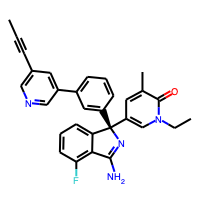
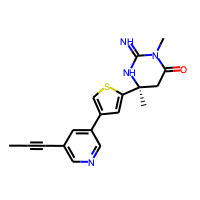
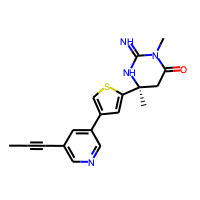
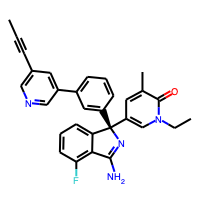
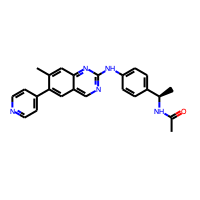
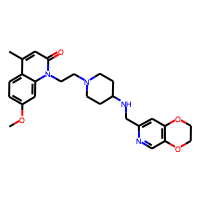
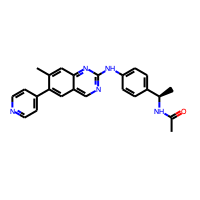
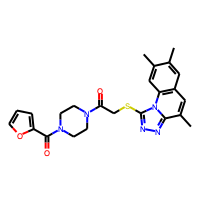
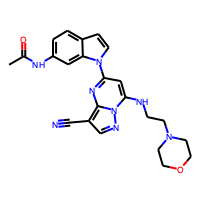
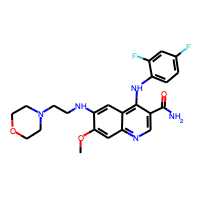
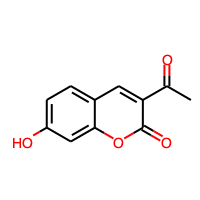
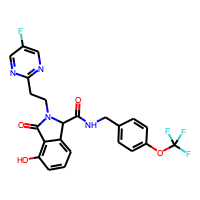
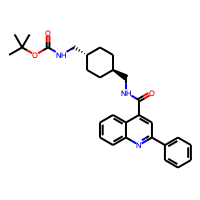
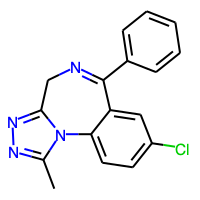
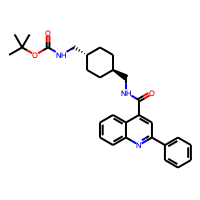
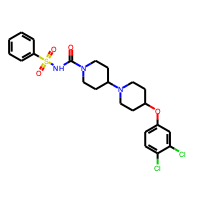
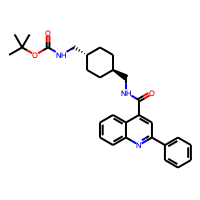
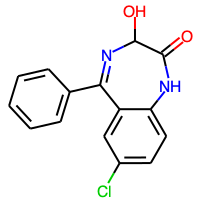
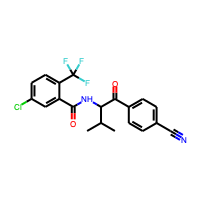
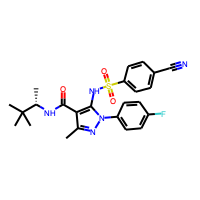
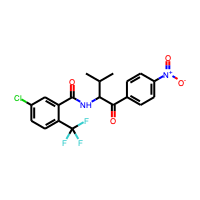
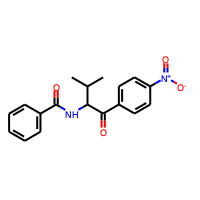
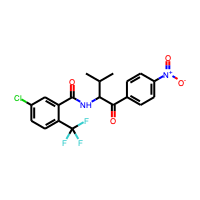
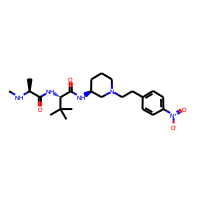
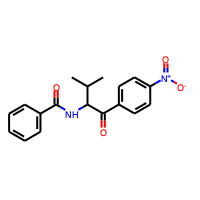
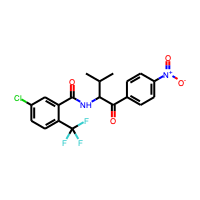
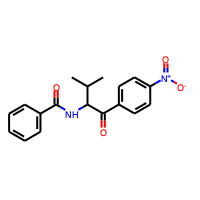
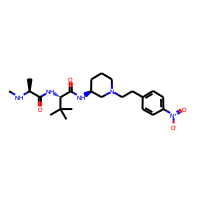
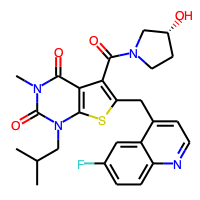
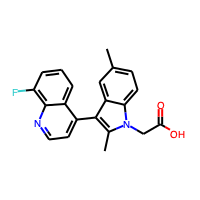
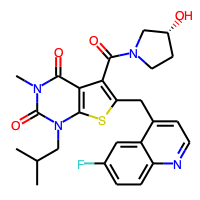
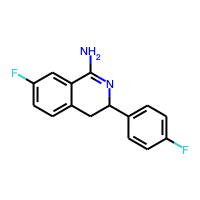
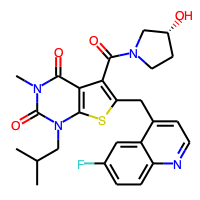
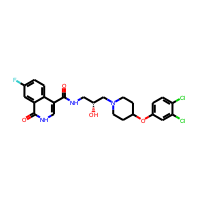
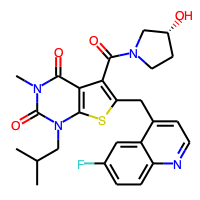
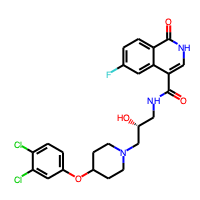
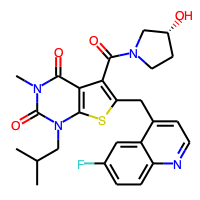
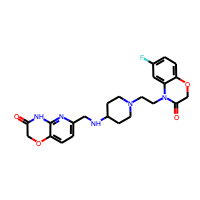
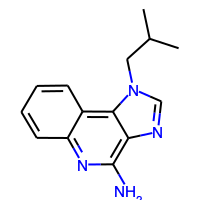
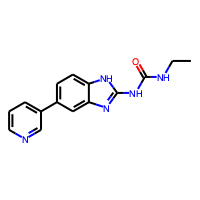
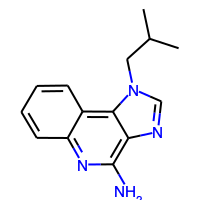
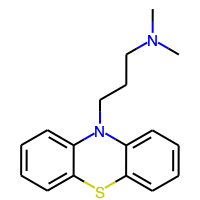
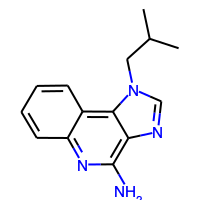
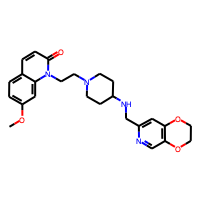
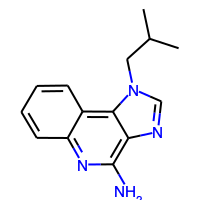
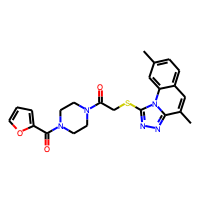
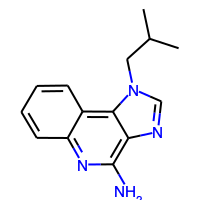
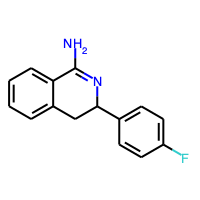
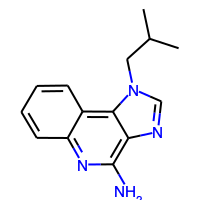
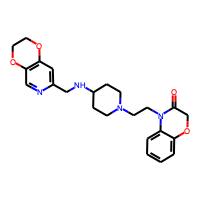
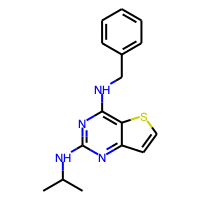
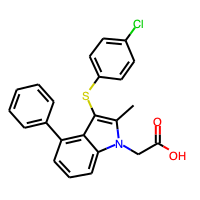
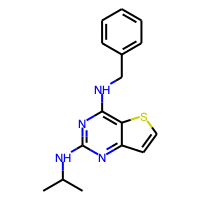
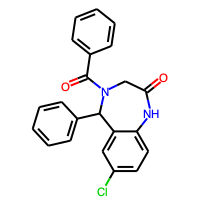
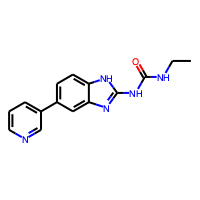
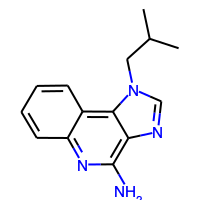
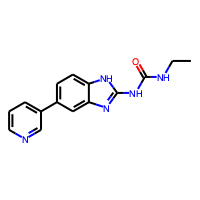
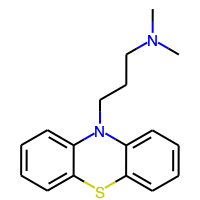
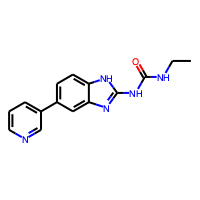
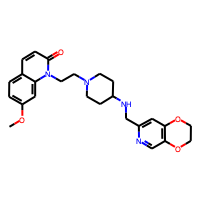
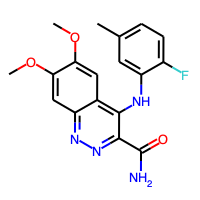
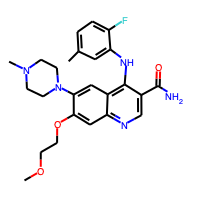
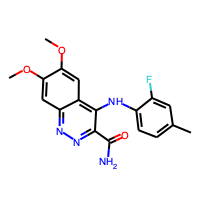
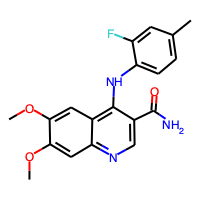
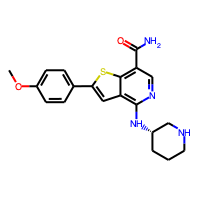
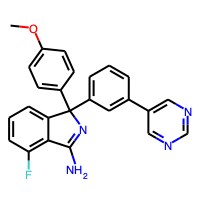
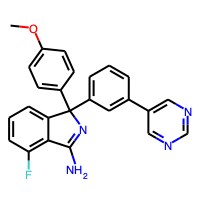
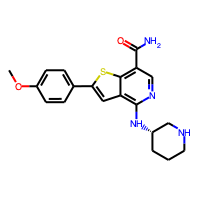
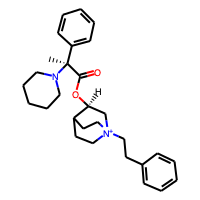
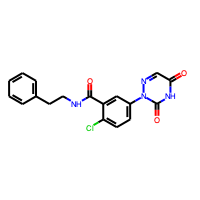
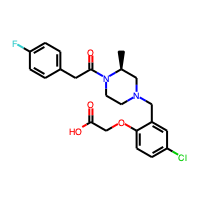
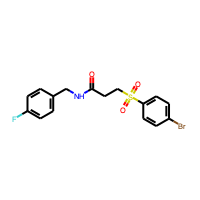
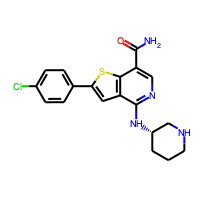
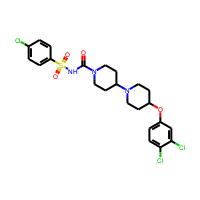
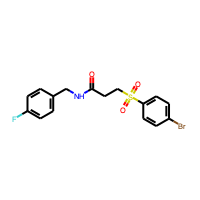
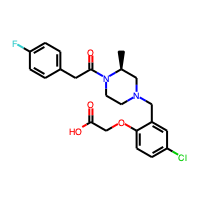
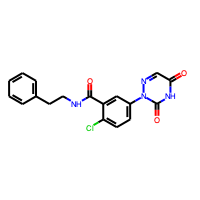
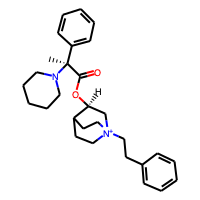
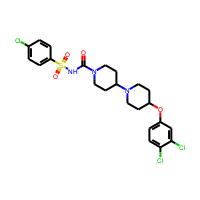
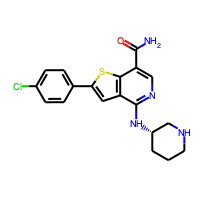
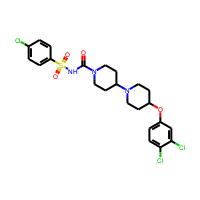
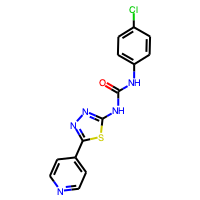
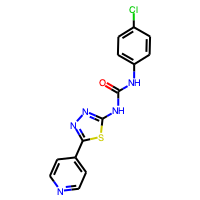
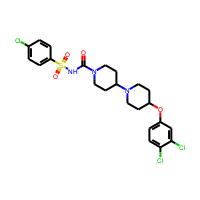
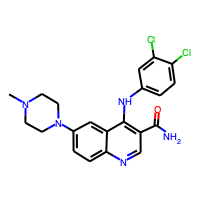
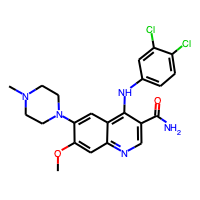
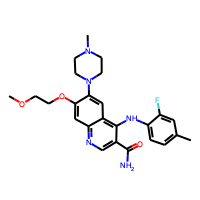
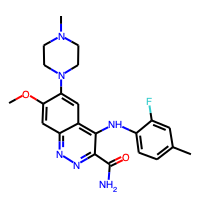
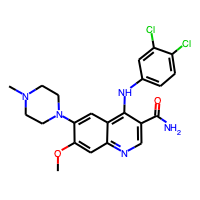
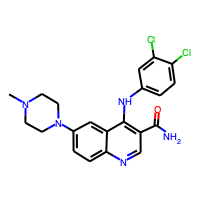
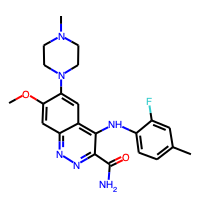
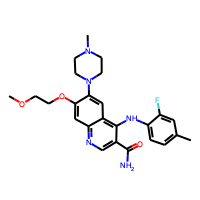
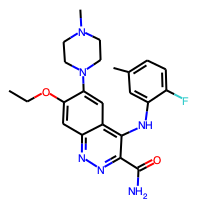
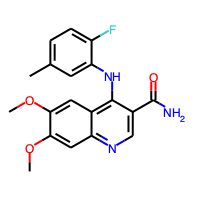
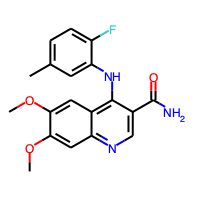
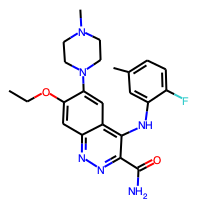
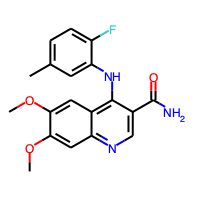
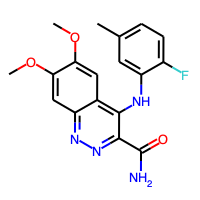
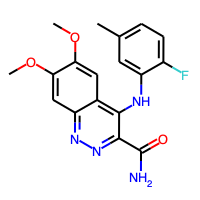
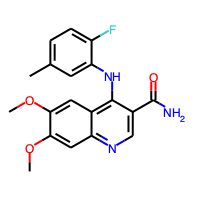
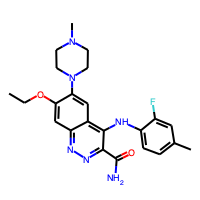
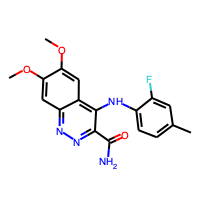
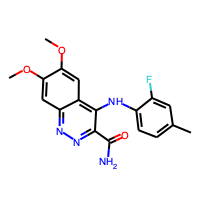
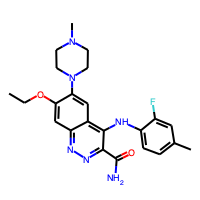
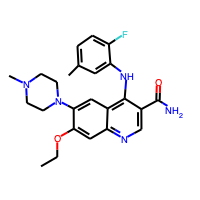
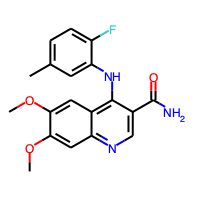
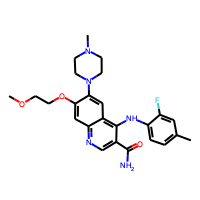
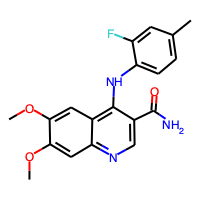
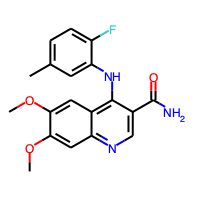
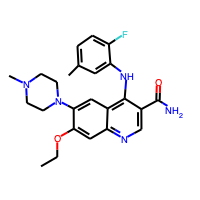
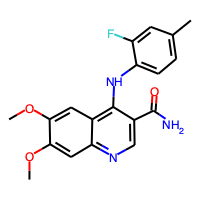
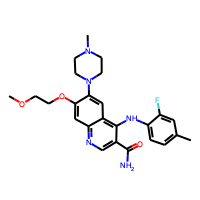
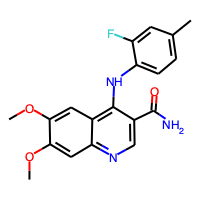
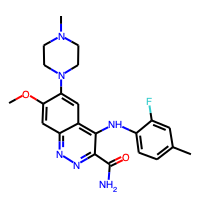
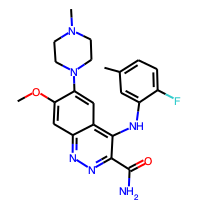
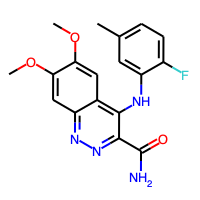
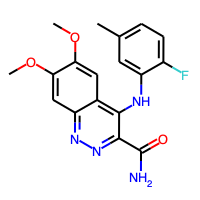
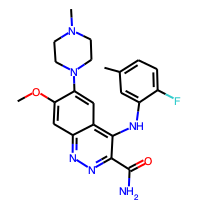
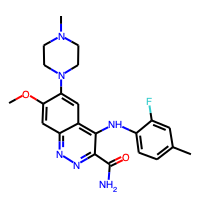
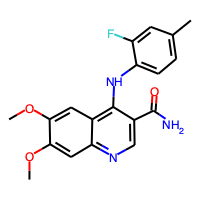

In [104]:
df.head(250)

### Degree - Number of fragments per compound node

In [128]:
data = graph_1.run("""
                CALL gds.alpha.degree.stream('fragsimgraph')
                YIELD nodeId, score
                RETURN gds.util.asNode(nodeId).smiles AS Compound1, gds.util.asNode(nodeId).compoundid as CID, score AS degree
                ORDER BY degree DESC
                """).data()

In [130]:
data = graph_1.run("""
                CALL gds.alpha.degree.write('fragsimgraph',{writeProperty: 'fragment_degree'})
                YIELD nodes, writeProperty
                """).data()

### Find me similar compounds based on their fragments

In [265]:
data = graph_1.run("""MATCH (n:Compound)-[m]-(p)
                      WHERE n.fragment_degree>=3
                      AND m.similarity_score IS NOT null 
                      AND startnode(m) = n
                      RETURN
                             DISTINCT n.compoundid AS cid1, n.smiles AS Compound1, n.fragment_degree,
                             p.compoundid AS cid2, p.smiles AS Compound2, p.fragment_degree, 
                             m.similarity_score
                      ORDER BY m.similarity_score DESC""").data()

In [266]:
df = pd.DataFrame(data)

In [267]:
PandasTools.AddMoleculeColumnToFrame(df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(df, 'Compound2','Compound2')

,Compound1,Compound2,cid1,cid2,m.similarity_score,n.fragment_degree,p.fragment_degree
0,,,307,311,1.0,17.0,17.0
1,,,310,312,1.0,15.0,15.0
2,,,311,307,1.0,17.0,17.0
3,,,312,310,1.0,15.0,15.0
4,,,578,580,1.0,3.0,3.0

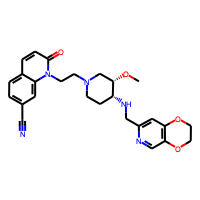
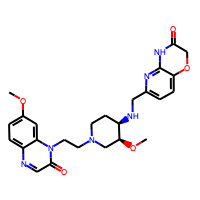
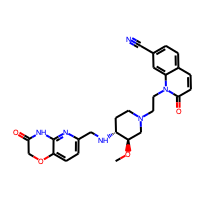
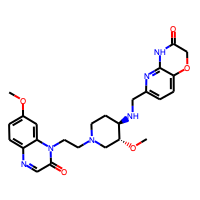
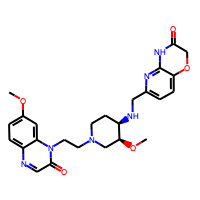
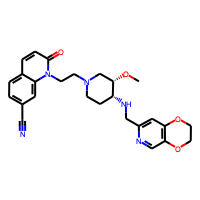
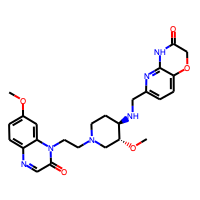
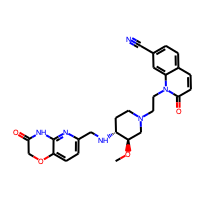
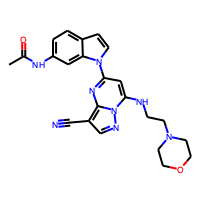
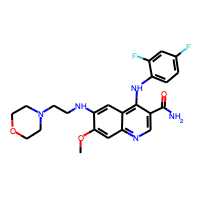

In [270]:
df.head()

### Find me fragments which are important, weighted by avg MMP change - maybe these are the ones that occur the most frequently?

In [305]:
data = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {relationshipWeightProperty:'avg', writeProperty:'fragment_pageRank'})
                """).data()

In [309]:
data = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {writeProperty:'fragment_pageRank_unweighted'})
                """).data()

In [310]:
data = graph_1.run("""
                MATCH (n:Fragment)
                WHERE EXISTS(n.fragment_pageRank)
                RETURN n.smiles, n.fragment_pageRank, n.fragment_pageRank_unweighted
                ORDER by n.fragment_pageRank DESC
                """).data()

In [313]:
df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(df, 'n.smiles','Fragment')

,n.fragment_pageRank,n.fragment_pageRank_unweighted,n.smiles,Fragment
0,4.114433,3.780301,[*:1]c1ccccc1,
1,3.499296,7.118977,[*:1][H],
2,2.378116,2.102223,[*:1]NC(C)=O,
3,2.195371,0.635886,[*:1]c1ccccc1N(C)C,
4,2.032635,0.329875,[*:1]NS(C)(=O)=O,
5,1.902379,1.547490,[*:1]c1ccccc1OC,
6,1.580521,1.808952,[*:1]c1ccccc1[*:2],
7,1.499931,0.806513,[*:1][C@@H]1CCCc2ccccc21,
8,1.493443,0.735985,[*:1]c1ccccc1N([*:2])C,
9,1.467752,1.938062,[*:1]c1ccco1,

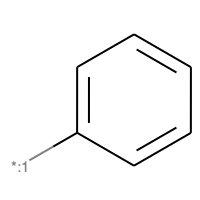
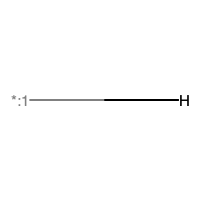
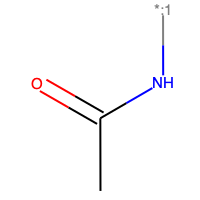
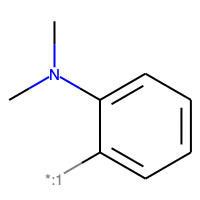
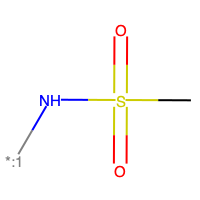
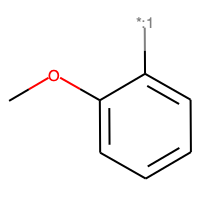
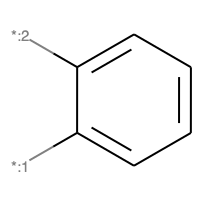
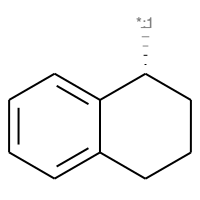
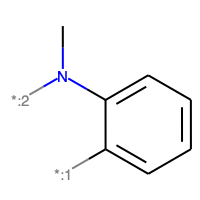
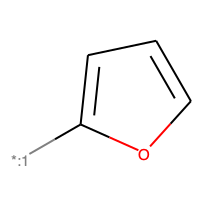
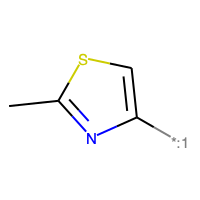
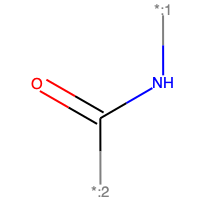
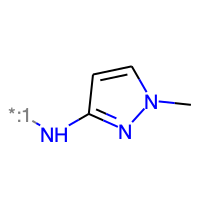
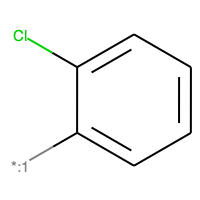
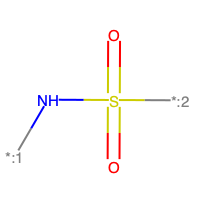
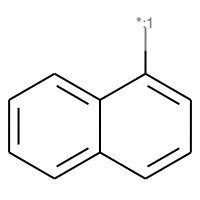
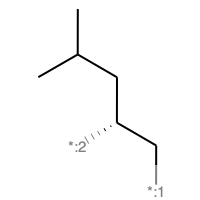
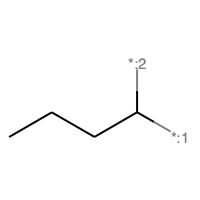
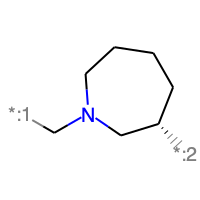
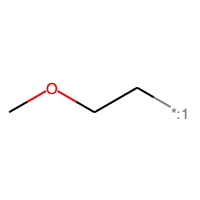
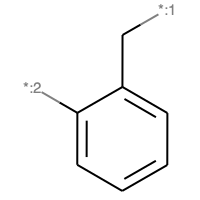
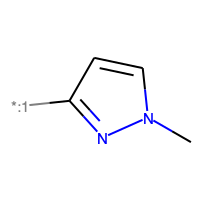
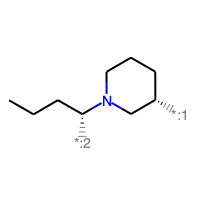
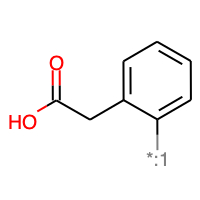
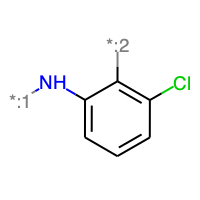
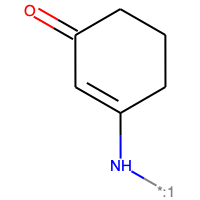
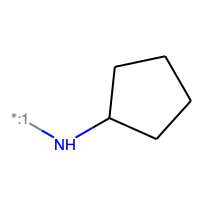
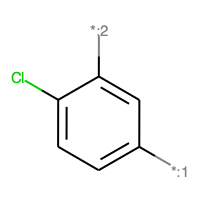
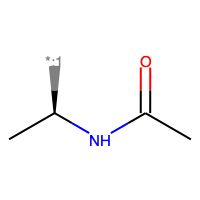
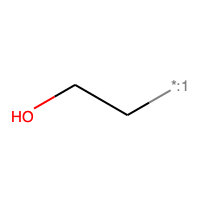
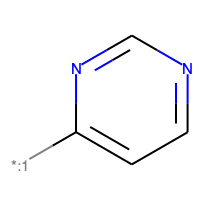
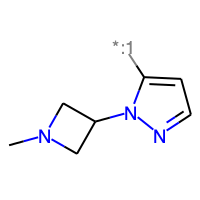
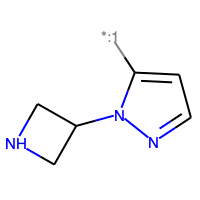
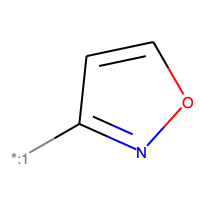
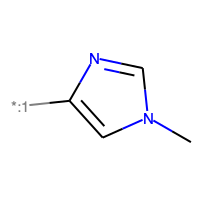
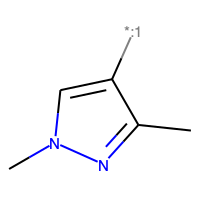
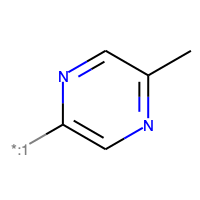
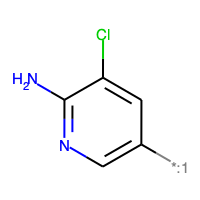
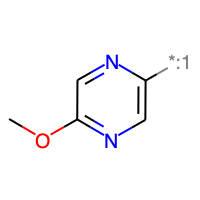
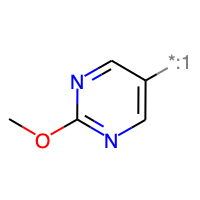
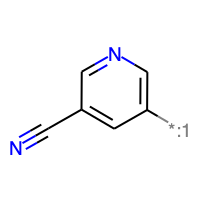
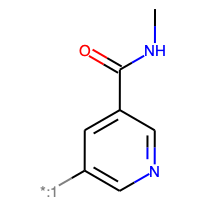
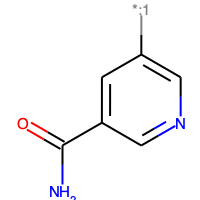
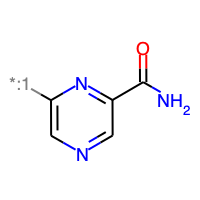
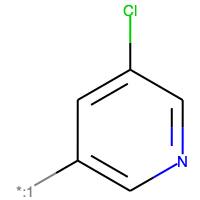
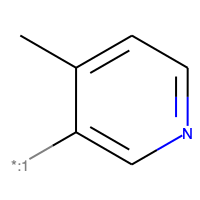
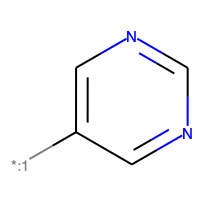
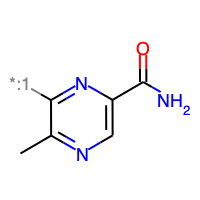
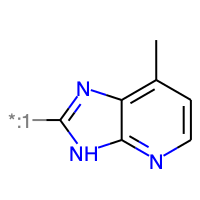
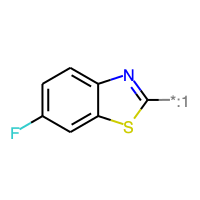
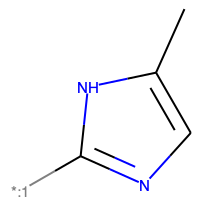
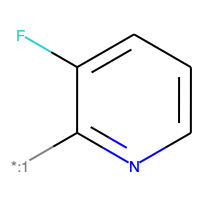
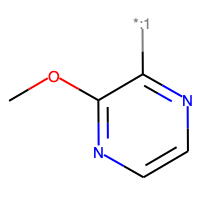
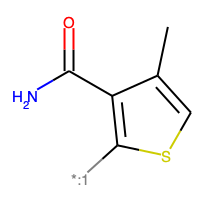
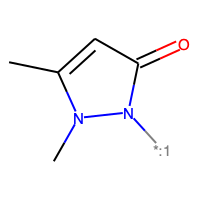
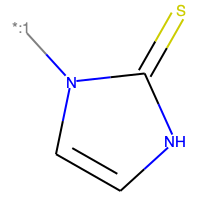
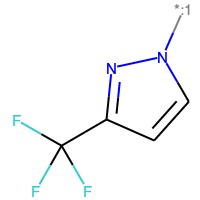
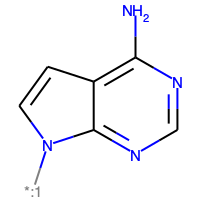
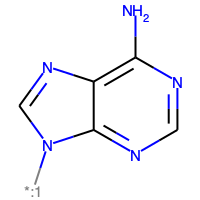
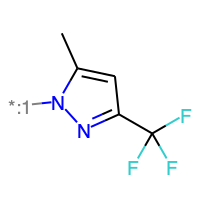

In [314]:
df